In [5]:
import os
import sys
import json
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte, io
import cv2
import glob

In [10]:
# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
    PerspectiveCameras, OrthographicCameras
)

# for glb
from pytorch3d.io import IO
from pytorch3d.io.experimental_gltf_io import MeshGlbFormat

def load_glb(path, **kwargs) -> Meshes:
    io = IO()
    io.register_meshes_format(MeshGlbFormat())
    return io.load_mesh(path, **kwargs)

def get_glb_file(target_glb, all_glbs):
    glb_file = None
    for glb in all_glbs:
        if target_glb in glb:
            glb_file = glb
    if glb_file is None:
        assert False, 'couldnt find glb file'
    return glb_file

## find glb directory and corresponding images

In [3]:
# load metadata
metadata_path = '/home/jazzie/ABO_RELEASE/listings/metadata'
json_paths = glob.glob(os.path.join(metadata_path, '*'))
metadata = []
for json_path in json_paths:
    for line in open(json_path, 'r'):
        metadata.append(json.loads(line))
print('metadata loaded')

# load images.csv
csv_path = '/home/jazzie/ABO_RELEASE/images/metadata/images.csv'
images_csv = []
with open(csv_path, 'r') as f:
    for line in f.readlines():
        images_csv.append(line.strip().split(','))
images_csv = images_csv[1:]

# construct dict from image_id to url
imageid2url = {}
for line in images_csv:
    imageid2url[line[0]] = 'https://amazon-berkeley-objects.s3.amazonaws.com/images/original/%s'%line[3]
print('images csv loaded')

# load all 3d dirs
all_glbs = []
for subdir in glob.glob(os.path.join('/home/jazzie/ABO_RELEASE/3dmodels/original', '*')):
    all_glbs.extend(glob.glob(os.path.join(subdir, '*')))

metadata loaded
images csv loaded


found it
dict_keys(['item_dimensions', 'brand', 'bullet_point', 'color', 'item_id', 'item_name', 'item_weight', 'material', 'model_number', 'product_type', 'style', 'spin_id', 'main_image_id', 'other_image_id', '3dmodel_id', 'item_keywords', 'color_code', 'country', 'marketplace', 'domain_name', 'node'])
['https://amazon-berkeley-objects.s3.amazonaws.com/images/original/e8/e82e65f5.jpg', 'https://amazon-berkeley-objects.s3.amazonaws.com/images/original/d5/d5c7ad8f.jpg', 'https://amazon-berkeley-objects.s3.amazonaws.com/images/original/1f/1fcec67c.jpg', 'https://amazon-berkeley-objects.s3.amazonaws.com/images/original/e1/e10ed05f.jpg', 'https://amazon-berkeley-objects.s3.amazonaws.com/images/original/5b/5b63a47c.jpg', 'https://amazon-berkeley-objects.s3.amazonaws.com/images/original/c4/c424c824.jpg']


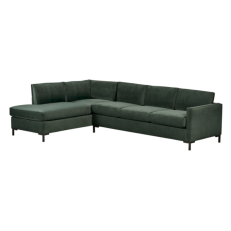

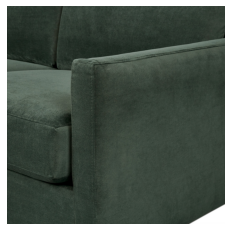

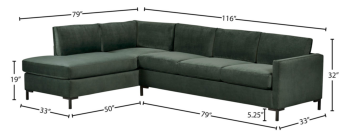

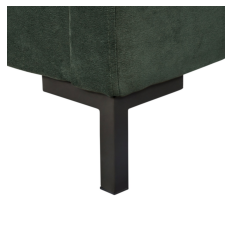

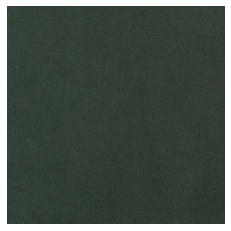

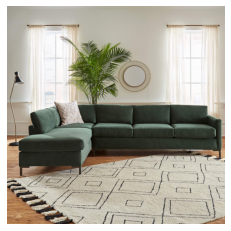

In [7]:
asin = 'B07B4FZN9H'
glb_file = get_glb_file(asin + '.glb', all_glbs)
images = []
for listing in metadata:
    if listing['item_id'] == asin:
        print('found it')
        print(listing.keys())
        try:
            image_ids = [listing['main_image_id']] + listing['other_image_id']
        except:
            try:
                image_ids = [listing['main_image_id']]
            except:
                print('no images')
        for image_id in image_ids:
            images.append(imageid2url[image_id])
print(images)
for image in images:
    im = io.imread(image)
    plt.imshow(im)
    plt.axis('off')
    plt.show()


In [176]:
# TESTING HERE!!
mask_path = '/home/jazzie/code/amazon-pose/B07B4FZN9H/c424c824_mask.jpg'
img_path = '/home/jazzie/code/amazon-pose/B07B4FZN9H/c424c824.jpg'

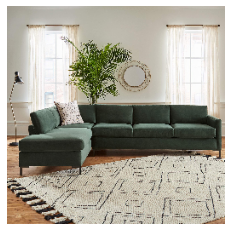

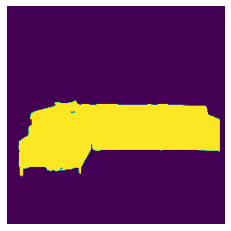

(1, 256, 256)
(256, 256, 3)
[0. 1.]


In [177]:
IMSIZE = 256
im = cv2.imread(img_path)
im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
im = cv2.resize(im, (IMSIZE, IMSIZE))
plt.imshow(im)
plt.axis('off')
plt.show()

im_sil = cv2.imread(mask_path, 0)
im_sil = cv2.resize(im_sil, (IMSIZE, IMSIZE))
plt.imshow(im_sil)
plt.axis('off')
plt.show()
im_sil = im_sil / 255.0
im_sil[im_sil<=0.5] = 0
im_sil[im_sil>0.5] = 1.0
im_sil = np.expand_dims(im_sil, axis=0)
print(im_sil.shape)
print(im.shape)
print(np.unique(im_sil))

In [11]:
device = torch.device("cuda:0")
glb_mesh = load_glb(glb_file, device=device)

verts = glb_mesh.verts_packed()
faces = glb_mesh.faces_packed()

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)
print(verts_rgb.shape)
textures = TexturesVertex(verts_features=verts_rgb.to(device))

# Create a Meshes object for the object. Here we have only one mesh in the batch.
mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

torch.Size([1, 13595, 3])


In [126]:
# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device) #, fov=45.0)
# cameras = PerspectiveCameras(device=device, focal_length=90)
# cameras = PerspectiveCameras(device=device, focal_length=120.0, principal_point=((128.0, 128.0),), image_size=((256, 256),))
# cameras = OrthographicCameras(device=device, focal_length=1.0)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
    perspective_correct=False,
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)


# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)
# We can add a point light in front of the object. 
lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

In [7]:
def make_square(im):
    h = im.shape[0]
    w = im.shape[1]
    if h == w:
        return im
    elif w < h:
        padamt = h - w
        if padamt % 2 == 0:
            padim = np.pad(im, ((0, 0), (padamt//2, padamt//2), (0, 0)), mode='constant', constant_values=255)
        else:
            padim = np.pad(im, ((0, 0), (padamt//2, padamt//2+1), (0, 0)), mode='constant', constant_values=255)
    else:
        padamt = w - h
        if padamt % 2 == 0:
            padim = np.pad(im, ((padamt//2, padamt//2), (0, 0), (0, 0)), mode='constant', constant_values=255)
        else:
            padim = np.pad(im, ((padamt//2, padamt//2+1), (0, 0), (0, 0)), mode='constant', constant_values=255)
    if padim.shape[0] != padim.shape[1]:
        assert False, 'failure in make_square'
    return padim

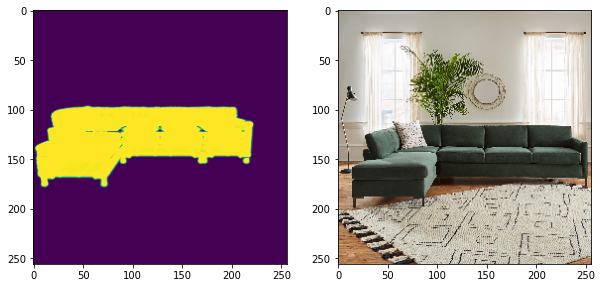

In [48]:
# Select the viewpoint using spherical angles  
distance = 4.0   # distance from camera to the object
elevation = 10.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device, at=((0.0, 0.5, 0.0), ))

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=mesh, R=R, T=T)
phong_image_ref = phong_renderer(meshes_world=mesh, R=R, T=T)

silhouete = silhouete.cpu().numpy()
phong_image_ref = phong_image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(im.squeeze())
plt.grid(False)

In [166]:
list(model.parameters())

[Parameter containing:
 tensor([0.0000, 1.0000, 5.0000, 0.0000, 0.8000, 0.0000], device='cuda:0',
        requires_grad=True)]

Starting loss tensor(7153.8506, device='cuda:0', grad_fn=<SumBackward0>)


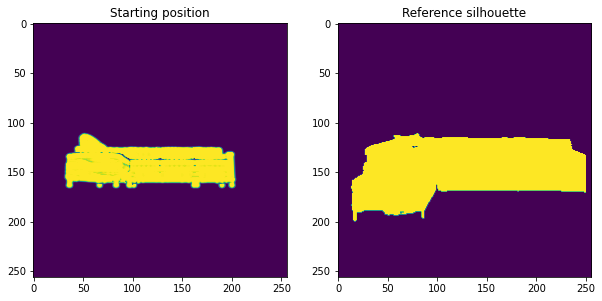

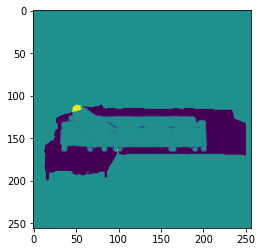

In [170]:
# can try
# I've declared all these parameters as nn.Parameters in my model.
# self.camera_position = nn.Parameter( torch.from_numpy(np.array(start_cam_T, dtype=np.float32)).to(self.device))
# self.camera_rotation = nn.Parameter( torch.from_numpy(np.array(start_cam_R, dtype=np.float32)).to(self.device))
# self.fov = nn.Parameter(torch.tensor(fov, requires_grad=True, device=self.device))

# In the forward method I do the following:
# R = pytorch3d.transforms.euler_angles_to_matrix(self.eulers, convention="XYZ")
# T = self.camera_position[None, :]

# image = self.renderer(meshes_world=self.meshes, R=R, T=T, cameras=camera, fov=self.fov)

class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        image_ref = torch.from_numpy(image_ref.astype(np.float32))
        self.register_buffer('image_ref', image_ref)

        # Create an optimizable parameter for the x, y, z position of the camera. 
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([0.0, 0.0, +5.0, 0.0, 0.8, 0.0], dtype=np.float32)).to(meshes.device))

    def forward(self):
        # Render the image using the updated camera position. Based on the new position of the 
        # camera we calculate the rotation and translation matrices
#         R = look_at_rotation(self.camera_position[None, :], device=self.device, at=(AT,))  # (1, 3, 3)
        R = look_at_rotation(self.camera_position[None, 0:3], device=self.device, at=self.camera_position[None,3:])
        
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, 0:3, None])[:, :, 0]   # (1, 3)
        
        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)
        
        # Calculate the silhouette loss
#         import pdb;pdb.set_trace()
#         np.unique(image[..., 3].cpu().numpy())
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
#         loss = torch.sum(torch.abs(image[..., 3] - self.image_ref))
        return loss, image
    
# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh, renderer=silhouette_renderer, image_ref=im_sil).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0005)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

plt.figure(figsize=(10, 10))

starting_loss, image_init = model()
print('Starting loss', starting_loss)
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");
plt.show()

plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3] - model.image_ref.cpu().numpy().squeeze())
plt.show()

In [171]:
# We will save images periodically and compose them into a GIF.
filename_output = "./teapot_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

loop = tqdm(range(500))
init_im = None
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f)' % loss.data)
    
    if loss.item() < 200:
        break
    
    # Save outputs to create a GIF. 
    if i % 100 == 0:
#         R = look_at_rotation(model.camera_position[None, :], device=model.device, at=(AT,))
        R = look_at_rotation(model.camera_position[None, 0:3], device=model.device, at=model.camera_position[None,3:])
        T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, 0:3, None])[:, :, 0]   # (1, 3)
        image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)
        
        if init_im is None:
            init_im = image
        
#         plt.figure()
#         plt.imshow(image[..., :3])
#         plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
#         plt.grid("off")
#         plt.axis("off")
    
writer.close()

  0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
def get_mask(im):
    sum_im = np.sum(im, axis=-1)
    white_locs = (sum_im == 3)
    mask = sum_im
    mask[white_locs] = 0.0
    mask[~white_locs] = 1.0
    return mask

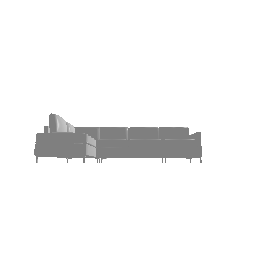

BEFORE


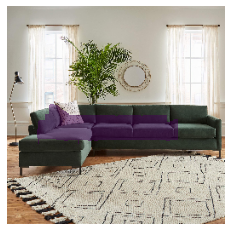

AFTER


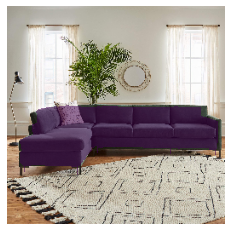

In [172]:
from IPython.display import Image
with open('teapot_optimization_demo.gif','rb') as f:
    display(Image(data=f.read(), format='png'))
    
print('BEFORE')
plt.imshow(im.squeeze())
plt.grid(False)
plt.axis('off')

init_im_mask = get_mask(init_im/255.0)
init_im_mask[init_im_mask==0] = np.nan
plt.imshow(init_im_mask, alpha=0.5)
plt.show()

print('AFTER')
plt.imshow(im.squeeze())
plt.grid(False)
plt.axis('off')

final_im_mask = get_mask(image/255.0)
final_im_mask[final_im_mask==0] = np.nan
plt.imshow(final_im_mask, alpha=0.5)
plt.show()